In [ ]:
!pip install -U datasets transformers peft accelerate evaluate scikit-learn torch
!pip install -U datasets numpy pyarrow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 139.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 16.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.0
    Uninstalling transformers-4.57.0:
      Successfully uninstalled transformers-4.57.0
  Attemptin

In [ ]:
import numpy as np
import evaluate
import math
import pandas as pd
import os
import json, pathlib
from datasets import ClassLabel, Dataset, DatasetDict
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import DataCollatorWithPadding
import torch
from peft import get_peft_model, LoraConfig, TaskType
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Read Dataset

In [ ]:
DATA_DIR = pathlib.Path("/content")

with open(DATA_DIR / "dataset.json") as f:
  raw = json.load(f)
with open(DATA_DIR / "post_id_divisions.json") as f:
  splits = json.load(f)

# Inspect available split keys (helpful sanity check)
print("Split keys found:", set(splits.keys()))

label2id = {"normal": 0, "offensive": 1, "hatespeech": 2}
id2label = {v: k for k, v in label2id.items()}

def _norm_label(s):
    s = str(s).lower().replace(" ", "").replace("_", "")
    if s in ("hate", "hatespeech"): s = "hatespeech"
    if s in ("offense", "offensivecontent", "offencive"): s = "offensive"
    if s in ("neutral", "normal"): s = "normal"
    return s

def extract_labels(item):
    out = []

    ann = item.get("annotators", None)
    if isinstance(ann, dict):
        v = ann.get("label", [])
        if isinstance(v, list): out.extend(v)
        elif isinstance(v, str): out.append(v)
    elif isinstance(ann, list):
        for a in ann:
            if isinstance(a, dict):
                v = a.get("label", [])
                if isinstance(v, list): out.extend(v)
                elif isinstance(v, str): out.append(v)

    labs = item.get("labels", None)
    if isinstance(labs, list):
        out.extend(labs)
    elif isinstance(labs, dict) and labs:
        # take the argmax label from count-dict
        out.append(max(labs.items(), key=lambda kv: kv[1])[0])

    single = item.get("label", None)
    if isinstance(single, str) and single:
        out.append(single)

    # normalise + filter
    norm = []
    for s in out:
        if not s:
            continue
        s = _norm_label(s)
        if s in label2id:
            norm.append(s)
    return norm


def get_text(item):
    # Prefer tokens; fall back to raw 'post'
    toks = item.get("post_tokens", None)
    if isinstance(toks, list) and len(toks) > 0:
        toks = [t if isinstance(t, str) else str(t) for t in toks]
        return " ".join(toks)
    if isinstance(item.get("post"), str):
        return item["post"]
    return ""

def majority_label(item):
    labs = extract_labels(item)
    if not labs:
        return None
    return Counter(labs).most_common(1)[0][0]

def example_from_postid(pid):
    item = raw.get(pid, {})
    text = get_text(item)
    y = majority_label(item)
    if not text or y is None:
        return None
    return {"id": pid, "text": text, "labels": label2id[y]}

def build_split(name):
    kept, skipped = [], 0
    for pid in splits[name]:
        ex = example_from_postid(pid)
        if ex is None:
            skipped += 1
            continue
        kept.append(ex)
    print(f"[{name}] kept {len(kept)} examples, skipped {skipped} (missing text/label).")
    return kept

# Detect validation key
VAL_KEY = "val" if "val" in splits else ("validation" if "validation" in splits else None)
assert VAL_KEY is not None, "Expected a 'val' or 'validation' key in post_id_divisions.json"

train = Dataset.from_list(build_split("train"))
val   = Dataset.from_list(build_split(VAL_KEY))
test  = Dataset.from_list(build_split("test"))

ds = DatasetDict(train=train, validation=val, test=test)

print(ds)
print(ds["train"][0])



Split keys found: {'test', 'train', 'val'}
[train] kept 15383 examples, skipped 0 (missing text/label).
[val] kept 1922 examples, skipped 0 (missing text/label).
[test] kept 1924 examples, skipped 0 (missing text/label).
DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'labels'],
        num_rows: 15383
    })
    validation: Dataset({
        features: ['id', 'text', 'labels'],
        num_rows: 1922
    })
    test: Dataset({
        features: ['id', 'text', 'labels'],
        num_rows: 1924
    })
})
{'id': '23107796_gab', 'text': 'u really think i would not have been raped by feral hindu or muslim back in india or bangladesh and a neo nazi would rape me as well just to see me cry', 'labels': 1}


# Check for data imbalance

In [ ]:
# Check training set label distribution
label_counts = Counter(ds["train"]["labels"])
df_counts = pd.DataFrame.from_dict(label_counts, orient="index", columns=["count"])
df_counts["percentage"] = df_counts["count"] / df_counts["count"].sum() * 100
df_counts = df_counts.sort_values("count", ascending=False)
display(df_counts)


,count,percentage
0,6251,40.635767
2,4748,30.865241
1,4384,28.498992


# Bert Tokenization

In [ ]:
# Tokenizer + tokenized dataset

MODEL_NAME = "bert-base-uncased"
MAX_LEN = 256
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tok(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=MAX_LEN)

# keep "labels", drop everthing else except what's needed
cols_keep = ["text", "labels"]
drop_cols = [c for c in ds["train"].column_names if c not in cols_keep]

ds_tok = ds.map(tok, batched=True, batch_size=32, remove_columns=drop_cols)
ds_tok = ds_tok.remove_columns(["text"])
ds_tok = ds_tok.with_format("torch")

print(ds_tok)
print(ds_tok["train"][0].keys())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/15383 [00:00<?, ? examples/s]

Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

Map:   0%|          | 0/1924 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 15383
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1922
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1924
    })
})
dict_keys(['labels', 'input_ids', 'token_type_ids', 'attention_mask'])


In [ ]:
# Metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "macro_f1": f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }


num_labels = 3

# BERT Full Fine-Tuning

In [ ]:
# Full fine-tuning
# model
use_gpu = torch.cuda.is_available()

model_full = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

args_full = TrainingArguments(
    output_dir="runs/full_ft",
    learning_rate=2e-5,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    logging_steps=50,
    report_to="none",
    seed=42,
    fp16=use_gpu,
    dataloader_num_workers=2,
    dataloader_pin_memory=use_gpu,
)

trainer_full = Trainer(
    model=model_full,
    args=args_full,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["validation"],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

print("CUDA available:", torch.cuda.is_available())
trainer_full.train()
print("Best (full FT) on validation:", trainer_full.evaluate(ds_tok["validation"]))
print("Test (full FT):", trainer_full.evaluate(ds_tok["test"]))


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CUDA available: True


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.726700,0.725999,0.688345,0.666755
2,0.602900,0.717879,0.702914,0.691973
3,0.488100,0.770998,0.702914,0.688760


Best (full FT) on validation: {'eval_loss': 0.7178789377212524, 'eval_accuracy': 0.7029136316337149, 'eval_macro_f1': 0.6919734742789648, 'eval_runtime': 6.2947, 'eval_samples_per_second': 305.337, 'eval_steps_per_second': 9.691, 'epoch': 3.0}
Test (full FT): {'eval_loss': 0.7058556079864502, 'eval_accuracy': 0.7021829521829522, 'eval_macro_f1': 0.6883160434388165, 'eval_runtime': 6.3763, 'eval_samples_per_second': 301.742, 'eval_steps_per_second': 9.567, 'epoch': 3.0}


# LoRA on BERT

In [ ]:
# parameter-efficient fine-tuning (PEFT) with LoRA
target_modules = ["query", "value", "key", "dense"]  # for BERT-like models

peft_cfg = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    target_modules=target_modules
)

model_base = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
model_lora = get_peft_model(model_base, peft_cfg)
model_lora.print_trainable_parameters()  # sanity check

args_lora = TrainingArguments(
    output_dir="runs/lora",
    learning_rate=1e-4,          # LoRA can use a slightly higher LR
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    logging_steps=50,
    report_to="none",
    seed=42,
    fp16=use_gpu,
    dataloader_num_workers=2,
    dataloader_pin_memory=use_gpu,
)

trainer_lora = Trainer(
    model=model_lora,
    args=args_lora,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

trainer_lora.train()
print("Best (LoRA) on validation:", trainer_lora.evaluate(ds_tok["validation"]))
print("Test (LoRA):", trainer_lora.evaluate(ds_tok["test"]))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-20158422.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lora = Trainer(


trainable params: 1,341,699 || all params: 110,826,246 || trainable%: 1.2106


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.799300,0.765336,0.674818,0.652172
2,0.693600,0.724738,0.691988,0.677901
3,0.670000,0.725827,0.689906,0.674369


Best (LoRA) on validation: {'eval_loss': 0.7247380614280701, 'eval_accuracy': 0.6919875130072841, 'eval_macro_f1': 0.6779006657010376, 'eval_runtime': 10.0619, 'eval_samples_per_second': 191.018, 'eval_steps_per_second': 6.062, 'epoch': 3.0}
Test (LoRA): {'eval_loss': 0.7155118584632874, 'eval_accuracy': 0.6865904365904366, 'eval_macro_f1': 0.6688904118254855, 'eval_runtime': 10.0725, 'eval_samples_per_second': 191.014, 'eval_steps_per_second': 6.056, 'epoch': 3.0}


# RoBERTa Tokenization

In [ ]:
MODEL_NAME_2 = "roberta-base"   # <-- switch here
MAX_LEN = 256

rb_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME_2, use_fast=True)

def rb_tok(batch):
    return rb_tokenizer(batch["text"], truncation=True, padding="max_length", max_length=MAX_LEN)

cols_keep = ["text", "labels"]
drop_cols = [c for c in ds["train"].column_names if c not in cols_keep]

ds_tok_rb = ds.map(rb_tok, batched=True, batch_size=32, remove_columns=drop_cols)
ds_tok_rb = ds_tok_rb.remove_columns(["text"]).with_format("torch")

print(ds_tok_rb)
print(ds_tok_rb["train"][0].keys())

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/15383 [00:00<?, ? examples/s]

Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

Map:   0%|          | 0/1924 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 15383
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1922
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1924
    })
})
dict_keys(['labels', 'input_ids', 'attention_mask'])


# RoBERTa Full Fine-Tuning

In [ ]:
model_full_rb = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME_2, num_labels=num_labels,
                                                                   id2label=id2label, label2id=label2id)

use_gpu = torch.cuda.is_available()
data_collator = DataCollatorWithPadding(tokenizer=rb_tokenizer)

args_full_rb = TrainingArguments(
    output_dir="runs/roverta_full",
    learning_rate=2e-5,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    logging_steps=50,
    report_to="none",
    seed=42,
    fp16=use_gpu,
    dataloader_num_workers=2,
    dataloader_pin_memory=use_gpu,
)

trainer_full_rb = Trainer(
    model=model_full_rb,
    args=args_full_rb,
    train_dataset=ds_tok_rb["train"],
    eval_dataset=ds_tok_rb["validation"],
    processing_class=rb_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

print("CUDA:", use_gpu)
trainer_full_rb.train()
print("Best (RoBERTa full FT) val:", trainer_full_rb.evaluate(ds_tok_rb["validation"]))
print("Test (RoBERTa full FT):", trainer_full_rb.evaluate(ds_tok_rb["test"]))

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CUDA: True


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.762800,0.743344,0.673257,0.644060
2,0.619500,0.720381,0.703434,0.692122
3,0.562700,0.750605,0.706556,0.696661


Best (RoBERTa full FT) val: {'eval_loss': 0.7506052255630493, 'eval_accuracy': 0.7065556711758585, 'eval_macro_f1': 0.696660849193998, 'eval_runtime': 5.9413, 'eval_samples_per_second': 323.496, 'eval_steps_per_second': 10.267, 'epoch': 3.0}
Test (RoBERTa full FT): {'eval_loss': 0.7512463927268982, 'eval_accuracy': 0.6912681912681913, 'eval_macro_f1': 0.6779576444511025, 'eval_runtime': 6.0017, 'eval_samples_per_second': 320.577, 'eval_steps_per_second': 10.164, 'epoch': 3.0}


# LoRA on RoBERTa

In [ ]:
# RoBERTa LoRA targets:
target_modules_rb = ["query", "key", "value", "dense"]

peft_cfg_rb = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    target_modules=target_modules_rb,
)

base_rb = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME_2, num_labels=num_labels, id2label=id2label, label2id=label2id
)

model_lora_rb = get_peft_model(base_rb, peft_cfg_rb)
model_lora_rb.print_trainable_parameters()

args_lora_rb = TrainingArguments(
    output_dir="runs/roberta_lora",
    learning_rate=1e-4,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    logging_steps=50,
    report_to="none",
    seed=42,
    fp16=use_gpu,
    dataloader_num_workers=2,
    dataloader_pin_memory=use_gpu,
)

trainer_lora_rb = Trainer(
    model=model_lora_rb,
    args=args_lora_rb,
    train_dataset=ds_tok_rb["train"],
    eval_dataset=ds_tok_rb["validation"],
    processing_class=rb_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

trainer_lora_rb.train()
print("Best (RoBERTa LoRA) val:", trainer_lora_rb.evaluate(ds_tok_rb["validation"]))
print("Test (RoBERTa LoRA):", trainer_lora_rb.evaluate(ds_tok_rb["test"]))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,920,003 || all params: 126,567,942 || trainable%: 1.5170


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.791700,0.745606,0.674818,0.654298
2,0.693700,0.717578,0.692508,0.679852
3,0.676100,0.719756,0.696150,0.679039


Best (RoBERTa LoRA) val: {'eval_loss': 0.7175779342651367, 'eval_accuracy': 0.6925078043704475, 'eval_macro_f1': 0.6798521521654951, 'eval_runtime': 9.8554, 'eval_samples_per_second': 195.019, 'eval_steps_per_second': 6.189, 'epoch': 3.0}
Test (RoBERTa LoRA): {'eval_loss': 0.7091241478919983, 'eval_accuracy': 0.6860706860706861, 'eval_macro_f1': 0.6686008648461971, 'eval_runtime': 9.8039, 'eval_samples_per_second': 196.249, 'eval_steps_per_second': 6.222, 'epoch': 3.0}


# Table For Comparison

In [ ]:
rows = [
    {
        "Model": "BERT-base (Full FT)",
        "Val Accuracy": 0.7018730489073881,
        "Val Macro F1": 0.6905631972919893,
        "Val Loss": 0.758634090423584,
        "Test Accuracy": 0.6897089397089398,
        "Test Macro F1": 0.6728606215810076,
        "Test Loss": 0.7820579409599304,
    },
    {
        "Model": "BERT-base (LoRA)",
        "Val Accuracy": 0.6919875130072841,
        "Val Macro F1": 0.6779006657010376,
        "Val Loss": 0.7247380614280701,
        "Test Accuracy": 0.6865904365904366,
        "Test Macro F1": 0.6688904118254855,
        "Test Loss": 0.7155118584632874,
    },
    {
        "Model": "RoBERTa-base (Full FT)",
        "Val Accuracy": 0.6945889698231009,
        "Val Macro F1": 0.6842150921631803,
        "Val Loss": 0.7254101634025574,
        "Test Accuracy": 0.7053014553014553,
        "Test Macro F1": 0.6922731022004629,
        "Test Loss": 0.716627299785614,
    },
    {
        "Model": "RoBERTa-base (LoRA)",
        "Val Accuracy": 0.6966701352757544,
        "Val Macro F1": 0.6798271270516856,
        "Val Loss": 0.7234437465667725,
        "Test Accuracy": 0.6990644490644491,
        "Test Macro F1": 0.6820784712134119,
        "Test Loss": 0.7228283286094666,
    },
]

df = pd.DataFrame(rows)

# Optional: round for cleaner printing
df_rounded = df.copy()
for col in df.columns:
    if col != "Model":
        df_rounded[col] = df_rounded[col].astype(float).round(4)

# Display in notebook
display(df_rounded)

# Save artifacts
out_dir = Path("artifacts")
out_dir.mkdir(parents=True, exist_ok=True)

csv_path = out_dir / "model_comparison_table.csv"
md_path  = out_dir / "model_comparison_table.md"
tex_path = out_dir / "model_comparison_table.tex"

df_rounded.to_csv(csv_path, index=False)


with open(md_path, "w") as f:
    f.write(df_rounded.to_markdown(index=False))


with open(tex_path, "w") as f:
    f.write(df_rounded.to_latex(index=False, escape=True))

print(f"Saved CSV   → {csv_path}")
print(f"Saved MD    → {md_path}")
print(f"Saved LaTeX → {tex_path}")


,Model,Val Accuracy,Val Macro F1,Val Loss,Test Accuracy,Test Macro F1,Test Loss
0,BERT-base (Full FT),0.7019,0.6906,0.7586,0.6897,0.6729,0.7821
1,BERT-base (LoRA),0.6920,0.6779,0.7247,0.6866,0.6689,0.7155
2,RoBERTa-base (Full FT),0.6946,0.6842,0.7254,0.7053,0.6923,0.7166
3,RoBERTa-base (LoRA),0.6967,0.6798,0.7234,0.6991,0.6821,0.7228


Saved CSV   → artifacts/model_comparison_table.csv
Saved MD    → artifacts/model_comparison_table.md
Saved LaTeX → artifacts/model_comparison_table.tex


# Confusion Matrices

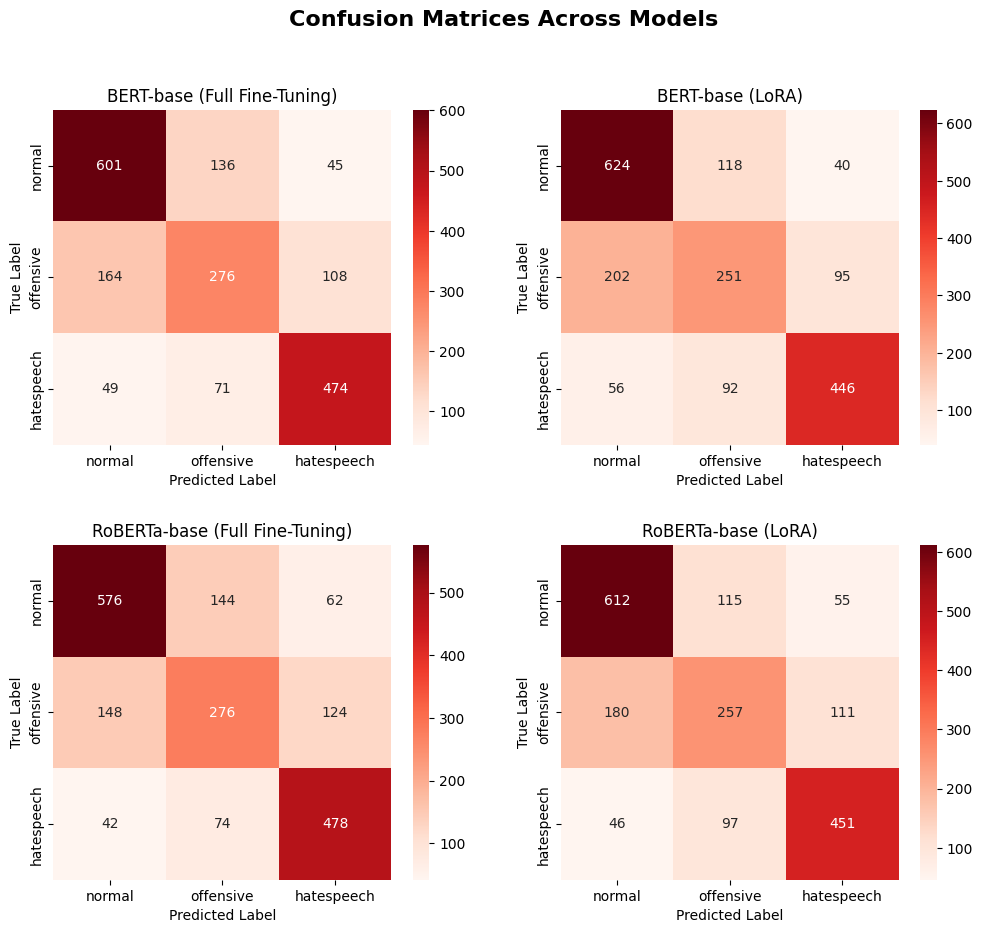

In [ ]:
# Helper function to compute predictions and confusion matrix
def get_conf_matrix(trainer, dataset, labels):
    preds = trainer.predict(dataset)
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=-1)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    return cm, y_true, y_pred

# Define label order and names
label_order = [0, 1, 2]
label_names = ["normal", "offensive", "hatespeech"]

# Compute confusion matrices for all models
cm_bert_ft, _, _ = get_conf_matrix(trainer_full, ds_tok["test"], label_order)
cm_bert_lora, _, _ = get_conf_matrix(trainer_lora, ds_tok["test"], label_order)
cm_roberta_ft, _, _ = get_conf_matrix(trainer_full_rb, ds_tok_rb["test"], label_order)
cm_roberta_lora, _, _ = get_conf_matrix(trainer_lora_rb, ds_tok_rb["test"], label_order)

# === Plot all four confusion matrices in one figure ===
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.3)

sns.heatmap(cm_bert_ft, annot=True, fmt="d", cmap="Reds", xticklabels=label_names, yticklabels=label_names, ax=axes[0,0])
axes[0,0].set_title("BERT-base (Full Fine-Tuning)")
axes[0,0].set_xlabel("Predicted Label")
axes[0,0].set_ylabel("True Label")

sns.heatmap(cm_bert_lora, annot=True, fmt="d", cmap="Reds", xticklabels=label_names, yticklabels=label_names, ax=axes[0,1])
axes[0,1].set_title("BERT-base (LoRA)")
axes[0,1].set_xlabel("Predicted Label")
axes[0,1].set_ylabel("True Label")

sns.heatmap(cm_roberta_ft, annot=True, fmt="d", cmap="Reds", xticklabels=label_names, yticklabels=label_names, ax=axes[1,0])
axes[1,0].set_title("RoBERTa-base (Full Fine-Tuning)")
axes[1,0].set_xlabel("Predicted Label")
axes[1,0].set_ylabel("True Label")

sns.heatmap(cm_roberta_lora, annot=True, fmt="d", cmap="Reds", xticklabels=label_names, yticklabels=label_names, ax=axes[1,1])
axes[1,1].set_title("RoBERTa-base (LoRA)")
axes[1,1].set_xlabel("Predicted Label")
axes[1,1].set_ylabel("True Label")

plt.suptitle("Confusion Matrices Across Models", fontsize=16, weight="bold")
plt.show()


# Qualitative Error Analysis (RoBERTa FT)

In [ ]:
# Get predictions for RoBERTa
preds = trainer_full_rb.predict(ds_tok_rb["test"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=-1)

# Map label IDs back to text
id2label = {0: "normal", 1: "offensive", 2: "hatespeech"}

# Retrieve examples
texts = ds["test"]["text"]  # original texts from dataset

errors = []
for i, (true, pred) in enumerate(zip(y_true, y_pred)):
    if true != pred:
        errors.append({
            "text": texts[i],
            "true_label": id2label[true],
            "pred_label": id2label[pred]
        })

# Convert to DataFrame for easier viewing
errors_df = pd.DataFrame(errors)
errors_df.sample(5, random_state=42)  # show 5 random misclassified samples


,text,true_label,pred_label
30,every job in the world exists solely to make a...,offensive,normal
299,if the greeks from <number> years ago could se...,hatespeech,normal
177,<number> of white women have non white babies ...,offensive,hatespeech
204,i hope the niglets keep going down on their kn...,offensive,hatespeech
354,do dykes keep their nails short,hatespeech,offensive
